In [1]:
import pandas as pd

data_df = pd.read_csv("c3_bike-sharing-data.csv")
data_df.head()

,temp,hum,windspeed,yr,workingday,holiday,weekday,season,weathersit,casual
0,0.344,0.806,0.160,2011,no,no,6,spring,cloudy,331
1,0.363,0.696,0.249,2011,no,no,0,spring,cloudy,131
2,0.196,0.437,0.248,2011,yes,no,1,spring,clear,120
3,0.200,0.590,0.160,2011,yes,no,2,spring,clear,108
4,0.227,0.437,0.187,2011,yes,no,3,spring,clear,82


In [2]:
from sklearn.model_selection import train_test_split

# One-hot encoding
encoded_df = pd.get_dummies(data_df)

# Split into train/test sets
X = encoded_df.drop("casual", axis=1).values
y = data_df.casual.values
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

In [3]:
from sklearn.preprocessing import StandardScaler

# Standardize data
scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

In [4]:
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_tr_rescaled, y_tr)
print("MAE: {:.2f}".format(MAE(y_te, ridge.predict(X_te))))

MAE: 255890.12


In [5]:
import numpy as np

median_predictions = np.full_like(y_te, np.median(y_tr))
print("Median baseline: {:.2f}".format(MAE(y_te, median_predictions)))

Median baseline: 523.47


In [6]:
# can see mistake was made by not using transformed X values
print("MAE: {:.2f}".format(MAE(y_te, ridge.predict(X_te_rescaled))))


MAE: 279.80


To avoid above mistake use PIPELINE

In [8]:
from sklearn.pipeline import Pipeline

# create pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])

In [9]:
# get dictionary with each step
pipe.named_steps

{'scaler': StandardScaler(), 'ridge': Ridge()}

In [10]:
# fit on train set
pipe.fit(X_tr, y_tr)

# evaluate on train set
print("MAE: {:.2f}".format(MAE(y_te, pipe.predict(X_te))))

MAE: 279.80


In [11]:
# pipe above is equivalent to using 

def pipe_fit(X, y):
    # Fit and apply the transformation
    X1 = scaler.fit_transform(X)

    # Fit the estimator
    ridge.fit(X1, y)


# Fit to the train data
pipe_fit(X_tr, y_tr)

# or 

def pipe_predict(X):
    # Apply the transformation
    X1 = scaler.transform(X)

    # Make predictions
    return ridge.predict(X1)


# Evaluate on the test set
print("MAE: {:.2f}".format(MAE(y_te, pipe_predict(X_te))))




MAE: 279.80


OPTIONAL

In [12]:
# Create a pipeline
pipe = Pipeline([("scaler", None), ("ridge", Ridge())])  # Disable this step

# Fit pipeline to the train set
pipe.fit(X_tr, y_tr)

# Accuracy on the test set
print("MAE: {:.2f}".format(MAE(y_te, pipe.predict(X_te))))

MAE: 282.48


Grid search with pipelines

In [13]:
import numpy as np

# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=100):
    # Create/fit the pipeline
    pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha))])
    pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mae": MAE(y_tr, pipe.predict(X_tr)),
            "test_mae": MAE(y_te, pipe.predict(X_te)),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.head()

,alpha,train_mae,test_mae
0,0.000100,262.057394,279.754483
1,0.000120,262.057392,279.754483
2,0.000145,262.057391,279.754485
3,0.000175,262.057389,279.754486
4,0.000210,262.057386,279.754487


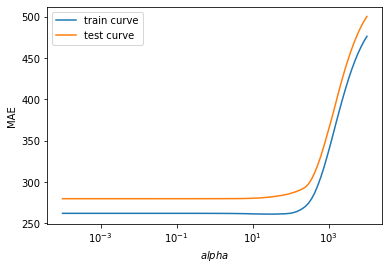

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.semilogx(gs_results["alpha"], gs_results["train_mae"], label="train curve")
plt.semilogx(gs_results["alpha"], gs_results["test_mae"], label="test curve")
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [15]:
# Create the pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()), ('ridge', Ridge())],
 'verbose': False,
 'scaler': StandardScaler(),
 'ridge': Ridge(),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': 'deprecated',
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

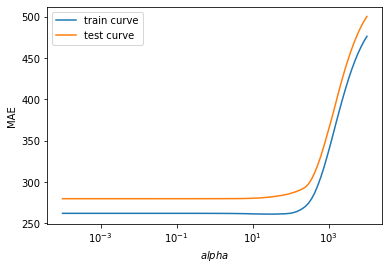

In [16]:
# Variable to store the results
gs_results = []

# Grid search
for alpha in np.logspace(-4, 4, num=100):
    # Fit the pipeline
    pipe.set_params(ridge__alpha=alpha)
    pipe.fit(X_tr, y_tr)

    # Save model and its performance on train/test sets
    gs_results.append(
        {
            "alpha": alpha,
            "train_mae": MAE(y_tr, pipe.predict(X_tr)),
            "test_mae": MAE(y_te, pipe.predict(X_te)),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)

# Plot the validation curves
plt.semilogx(gs_results["alpha"], gs_results["train_mae"], label="train curve")
plt.semilogx(gs_results["alpha"], gs_results["test_mae"], label="test curve")
plt.xlabel("$alpha$")
plt.ylabel("MAE")
plt.legend()
plt.show()